In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset
df = pd.read_csv('spotify_history.csv')

# Display shape and first few rows
print(df.shape)
df.head()


(149860, 11)


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [23]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with too many missing values or fill if appropriate
df.dropna(subset=['ts', 'artist_name', 'track_name', 'ms_played'], inplace=True)

# Convert endTime to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Add new time-based features
df['hour'] = df['ts'].dt.hour
df['day'] = df['ts'].dt.day_name()
df['month'] = df['ts'].dt.month_name()


spotify_track_uri      0
ts                     0
platform               0
ms_played              0
track_name             0
artist_name            0
album_name             0
reason_start         143
reason_end           117
shuffle                0
skipped                0
hour                   0
day                    0
month                  0
timeDiff               0
sessionID              0
time_diff              0
session_id             0
dtype: int64


In [24]:
print(df.columns.tolist())



['spotify_track_uri', 'ts', 'platform', 'ms_played', 'track_name', 'artist_name', 'album_name', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'hour', 'day', 'month', 'timeDiff', 'sessionID', 'time_diff', 'session_id']


In [26]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '')

# Now use the cleaned names
df.dropna(subset=['ts', 'artist_name', 'track_name', 'ms_played'], inplace=True)
df['ts'] = pd.to_datetime(df['ts'])


In [27]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '')

# Now use the cleaned names
df.dropna(subset=['ts', 'artist_name', 'track_name', 'ms_played'], inplace=True)
df['ts'] = pd.to_datetime(df['ts'])


In [28]:
df.to_csv("cleaned_spotify_history.csv", index=False)


In [29]:
# Convert to datetime (if not already done)
df['ts'] = pd.to_datetime(df['ts'])

# Create time-based features
df['hour'] = df['ts'].dt.hour
df['day'] = df['ts'].dt.day_name()
df['month'] = df['ts'].dt.month_name()


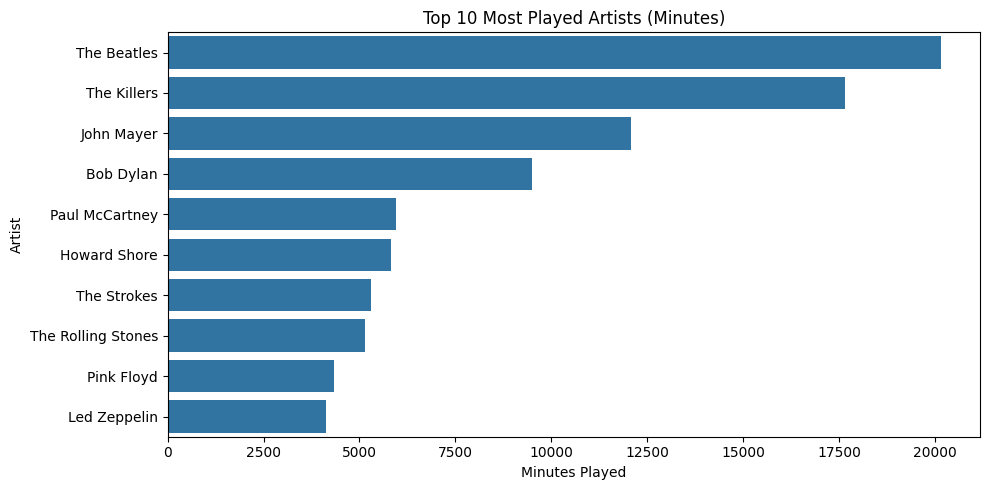

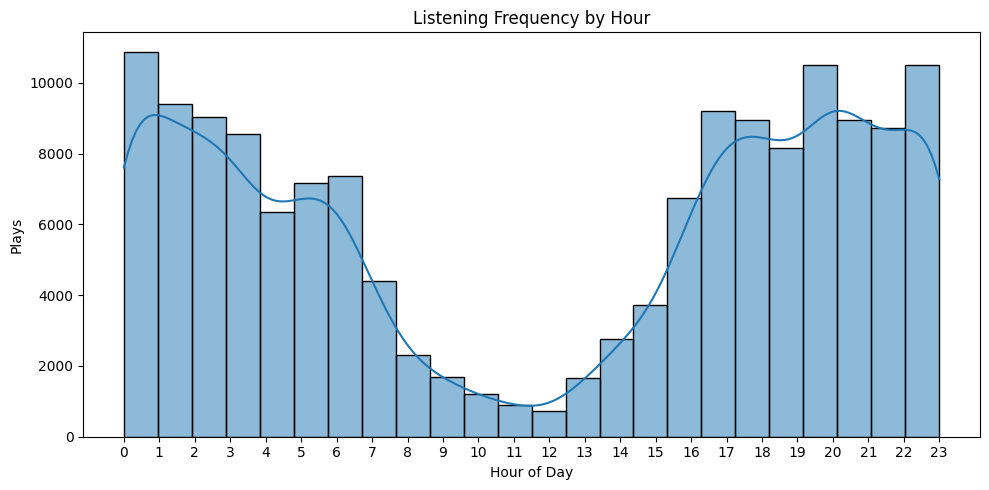

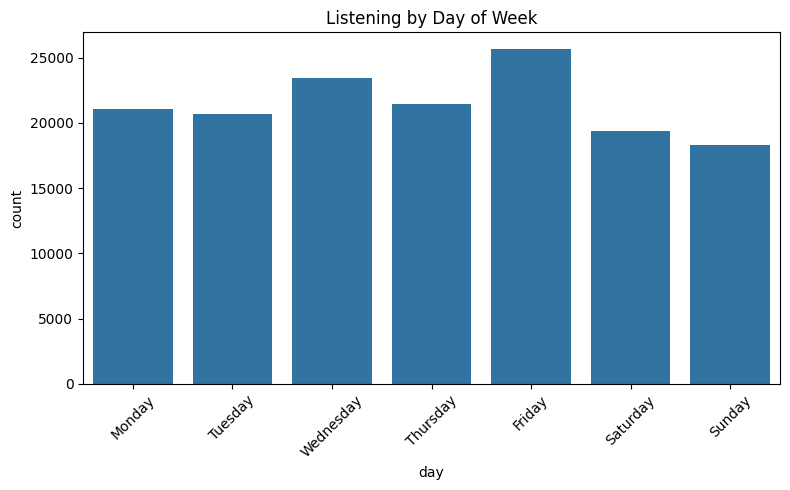

In [30]:
# Total playtime per artist
top_artists = df.groupby('artist_name')['ms_played'].sum().sort_values(ascending=False).head(10)
top_artists = top_artists / 1000 / 60  # convert ms to minutes

plt.figure(figsize=(10,5))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 10 Most Played Artists (Minutes)')
plt.xlabel('Minutes Played')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()

# Listening hour distribution
plt.figure(figsize=(10,5))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Listening Frequency by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Plays')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

# Songs played per day of the week
plt.figure(figsize=(8,5))
sns.countplot(x='day', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Listening by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
# Features for clustering
clustering_df = df.groupby(['hour', 'day']).agg({'ms_played': 'mean'}).reset_index()
pivot_table = clustering_df.pivot(index='day', columns='hour', values='ms_played').fillna(0)

# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(pivot_table)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)

pivot_table['Cluster'] = clusters

# Show clustering result
pivot_table['Cluster'].value_counts()


Cluster
1    5
2    1
0    1
Name: count, dtype: int64

In [32]:
# Evaluate clustering using silhouette score
score = silhouette_score(scaled, clusters)
print(f'Silhouette Score: {score:.2f}')


Silhouette Score: -0.03


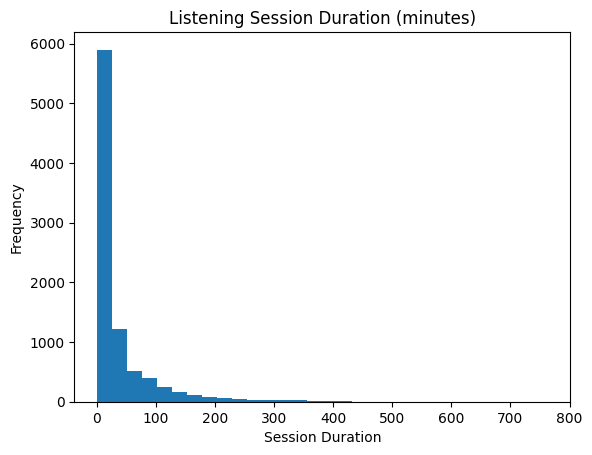

In [33]:
# Detect if multiple songs were played within short timeframes (e.g. sessions)
df = df.sort_values(by='ts')
df['timeDiff'] = df['ts'].diff().dt.total_seconds().fillna(0)
df['sessionID'] = (df['timeDiff'] > 1800).cumsum()  # new session after 30min

# Visualize sessions
session_lengths = df.groupby('sessionID')['ms_played'].sum() / 1000 / 60
plt.hist(session_lengths, bins=30)
plt.title('Listening Session Duration (minutes)')
plt.xlabel('Session Duration')
plt.ylabel('Frequency')
plt.show()


In [34]:
top_artists_df = df.groupby('artist_name')['ms_played'].sum().reset_index()
top_artists_df['minutes_played'] = top_artists_df['ms_played'] / 1000 / 60
top_artists_df.drop(columns='ms_played', inplace=True)
top_artists_df.to_csv('powerbi_top_artists.csv', index=False)


In [35]:
hourly_df = df.groupby('hour').size().reset_index(name='play_count')
hourly_df.to_csv('powerbi_hourly_distribution.csv', index=False)

day_df = df.groupby('day').size().reset_index(name='play_count')
day_df.to_csv('powerbi_day_distribution.csv', index=False)


In [36]:
df = df.sort_values(by='ts')
df['time_diff'] = df['ts'].diff().dt.total_seconds().fillna(0)
df['session_id'] = (df['time_diff'] > 1800).cumsum()

session_summary = df.groupby('session_id').agg({
    'ts': ['min', 'max'],
    'ms_played': 'sum'
}).reset_index()
session_summary.columns = ['session_id', 'session_start', 'session_end', 'total_ms_played']
session_summary['duration_minutes'] = session_summary['total_ms_played'] / 1000 / 60
session_summary.to_csv('powerbi_sessions.csv', index=False)


In [37]:
df.to_csv('powerbi_full_cleaned.csv', index=False)
